# Malaria Detection with VGG19 + Grad-CAM XAI

**Complete Pipeline with Explainable AI**

This notebook implements:
- VGG19 Transfer Learning (Phase 1: 50 epochs)
- Fine-tuning (Phase 2: 20 epochs)
- Optimal threshold tuning
- **Grad-CAM visual explanations**

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing import image
from PIL import Image
from scipy.ndimage import zoom

print('='*70)
print('GPU Available:', tf.config.list_physical_devices('GPU'))
print('TensorFlow Version:', tf.__version__)

2026-01-08 15:42:01.539290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-08 15:42:01.550191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-08 15:42:01.553649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 15:42:01.561832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 15:42:02.125527: W tensorflow/compiler/tf2

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow Version: 2.17.0


I0000 00:00:1767858122.736845 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1767858122.738475 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1767858122.772628 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1767858122.774025 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## CONFIGURATION

In [2]:
DATASET_PATH = '/home/user1/musab_2025/dataset/MalariaDataset'  # UPDATE THIS
NEGATIVE_PATH = os.path.join(DATASET_PATH, 'Negative')
POSITIVE_PATH = os.path.join(DATASET_PATH, 'Positive')
IMG_SIZE, BATCH_SIZE = 224, 16
EPOCHS_PHASE1, EPOCHS_PHASE2 = 50, 20
LEARNING_RATE_PHASE1, LEARNING_RATE_PHASE2 = 0.001, 1e-5
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.70, 0.15, 0.15
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

## LOAD DATASET

In [3]:
negative_images = [os.path.join(NEGATIVE_PATH, f) for f in os.listdir(NEGATIVE_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
positive_images = [os.path.join(POSITIVE_PATH, f) for f in os.listdir(POSITIVE_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_paths = negative_images + positive_images
labels = [0] * len(negative_images) + [1] * len(positive_images)
image_paths, labels = np.array(image_paths), np.array(labels)

print(f'Total: {len(image_paths)}, Ratio: {len(negative_images)/len(positive_images):.2f}:1')

X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=TEST_RATIO, stratify=labels, random_state=42)
val_size_adj = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size_adj, stratify=y_temp, random_state=42)

print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Total: 2990, Ratio: 2.51:1
Train: 2092, Val: 449, Test: 449


## CLASS WEIGHTS & DATA GENERATORS

In [4]:
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print(f'Weights: {class_weights}')

def create_dataframe(paths, labels):
    return pd.DataFrame({'filename': paths, 'class': labels.astype(str)})

train_df, val_df, test_df = create_dataframe(X_train, y_train), create_dataframe(X_val, y_val), create_dataframe(X_test, y_test)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='filename', y_col='class', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=True, seed=42)
val_gen = val_test_datagen.flow_from_dataframe(dataframe=val_df, x_col='filename', y_col='class', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)
test_gen = val_test_datagen.flow_from_dataframe(dataframe=test_df, x_col='filename', y_col='class', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Weights: {0: 0.6991978609625669, 1: 1.75503355704698}
Found 2092 validated image filenames belonging to 2 classes.
Found 449 validated image filenames belonging to 2 classes.
Found 449 validated image filenames belonging to 2 classes.


## BUILD & TRAIN MODEL

In [5]:
def build_vgg19(input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable_base=False):
    base_model = VGG19(weights='imagenet', input_shape=input_shape, include_top=False)
    base_model.trainable = trainable_base
    model = models.Sequential([base_model, layers.GlobalAveragePooling2D(), layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)), layers.BatchNormalization(), layers.Dropout(0.5), layers.Dense(1, activation='sigmoid')])
    return model, base_model

model, base_model = build_vgg19()
model.summary()

I0000 00:00:1767858153.414835 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1767858153.415899 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1767858153.417002 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1767858153.417950 2040985 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,993 (76.89 MB)

 Trainable params: 132,097 (516.00 KB)

 Non-trainable params: 20,024,896 (76.39 MB)

## PHASE 1: TRANSFER LEARNING

In [6]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1), loss='binary_crossentropy', metrics=[Precision(), Recall(), AUC(), 'accuracy'])
callbacks = [EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True), ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-7), ModelCheckpoint('malaria_phase1.h5', monitor='val_auc', save_best_only=True)]
history1 = model.fit(train_gen, epochs=EPOCHS_PHASE1, validation_data=val_gen, callbacks=callbacks, class_weight=class_weights, verbose=1)

Epoch 1/50


I0000 00:00:1767858162.219946 2041298 service.cc:146] XLA service 0x7cb5f0004940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767858162.219974 2041298 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1767858162.219978 2041298 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2026-01-08 15:42:42.302573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-08 15:42:42.669242: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  1/131 ━━━━━━━━━━━━━━━━━━━━ 11:06 5s/step - accuracy: 0.5625 - auc: 0.7083 - loss: 1.1162 - precision: 0.4286 - recall: 0.5000

I0000 00:00:1767858165.608320 2041298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7525 - auc: 0.8561 - loss: 0.8021 - precision: 0.5495 - recall: 0.8136

131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 540ms/step - accuracy: 0.8222 - auc: 0.9269 - loss: 0.6497 - precision: 0.6343 - recall: 0.8876 - val_accuracy: 0.9443 - val_auc: 0.9753 - val_loss: 0.4347 - val_precision: 0.9558 - val_recall: 0.8438 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.8953 - auc: 0.9539 - loss: 0.5149 - precision: 0.7736 - recall: 0.8943 - val_accuracy: 0.9287 - val_auc: 0.9722 - val_loss: 0.4265 - val_precision: 0.9706 - val_recall: 0.7734 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9005 - auc: 0.9599 - loss: 0.4805 - precision: 0.7788 - recall: 0.9097

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.9044 - auc: 0.9606 - loss: 0.4687 - precision: 0.7878 - recall: 0.9094 - val_accuracy: 0.9443 - val_auc: 0.9761 - val_loss: 0.3615 - val_precision: 0.8931 - val_recall: 0.9141 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9106 - auc: 0.9673 - loss: 0.4262 - precision: 0.8030 - recall: 0.9094 - val_accuracy: 0.9465 - val_auc: 0.9750 - val_loss: 0.3557 - val_precision: 0.9483 - val_recall: 0.8594 - learning_rate: 0.0010
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9102 - auc: 0.9720 - loss: 0.3986 - precision: 0.8074 - recall: 0.9116

131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 518ms/step - accuracy: 0.9149 - auc: 0.9723 - loss: 0.3919 - precision: 0.8119 - recall: 0.9128 - val_accuracy: 0.9510 - val_auc: 0.9764 - val_loss: 0.3289 - val_precision: 0.9077 - val_recall: 0.9219 - learning_rate: 0.0010
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9203 - auc: 0.9676 - loss: 0.4034 - precision: 0.8477 - recall: 0.8911

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.9125 - auc: 0.9651 - loss: 0.4009 - precision: 0.8134 - recall: 0.8993 - val_accuracy: 0.9577 - val_auc: 0.9773 - val_loss: 0.3083 - val_precision: 0.9580 - val_recall: 0.8906 - learning_rate: 0.0010
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 499ms/step - accuracy: 0.9269 - auc: 0.9698 - loss: 0.3708 - precision: 0.8402 - recall: 0.9178 - val_accuracy: 0.9154 - val_auc: 0.9726 - val_loss: 0.4168 - val_precision: 0.7848 - val_recall: 0.9688 - learning_rate: 0.0010
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 512ms/step - accuracy: 0.9216 - auc: 0.9733 - loss: 0.3471 - precision: 0.8323 - recall: 0.9077 - val_accuracy: 0.9577 - val_auc: 0.9762 - val_loss: 0.2893 - val_precision: 0.9360 - val_recall: 0.9141 - learning_rate: 0.0010
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.9216 - auc: 0.9694 - loss: 0.3514 - precision: 0.8313 - recall: 0.9094 - val_accuracy: 0.9443 - val_auc: 0.9770 - val_loss: 0.3031 - va

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 512ms/step - accuracy: 0.9216 - auc: 0.9737 - loss: 0.3288 - precision: 0.8224 - recall: 0.9245 - val_accuracy: 0.9621 - val_auc: 0.9796 - val_loss: 0.2831 - val_precision: 0.9237 - val_recall: 0.9453 - learning_rate: 5.0000e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 508ms/step - accuracy: 0.9350 - auc: 0.9750 - loss: 0.3183 - precision: 0.8506 - recall: 0.9362 - val_accuracy: 0.9555 - val_auc: 0.9780 - val_loss: 0.2645 - val_precision: 0.9286 - val_recall: 0.9141 - learning_rate: 5.0000e-04
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 518ms/step - accuracy: 0.9321 - auc: 0.9780 - loss: 0.3023 - precision: 0.8514 - recall: 0.9228 - val_accuracy: 0.9510 - val_auc: 0.9768 - val_loss: 0.2664 - val_precision: 0.9141 - val_recall: 0.9141 - learning_rate: 5.0000e-04
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9235 - auc: 0.9802 - loss: 0.2947 - precision: 0.8319 - recall: 0.9213

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.9273 - auc: 0.9743 - loss: 0.3098 - precision: 0.8384 - recall: 0.9228 - val_accuracy: 0.9555 - val_auc: 0.9797 - val_loss: 0.2469 - val_precision: 0.9286 - val_recall: 0.9141 - learning_rate: 5.0000e-04
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9334 - auc: 0.9806 - loss: 0.2833 - precision: 0.8472 - recall: 0.9359

131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 516ms/step - accuracy: 0.9293 - auc: 0.9793 - loss: 0.2903 - precision: 0.8415 - recall: 0.9262 - val_accuracy: 0.9532 - val_auc: 0.9806 - val_loss: 0.2478 - val_precision: 0.9084 - val_recall: 0.9297 - learning_rate: 5.0000e-04
Epoch 15/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.9264 - auc: 0.9769 - loss: 0.2940 - precision: 0.8369 - recall: 0.9211 - val_accuracy: 0.9488 - val_auc: 0.9805 - val_loss: 0.2621 - val_precision: 0.8723 - val_recall: 0.9609 - learning_rate: 5.0000e-04
Epoch 16/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9439 - auc: 0.9828 - loss: 0.2599 - precision: 0.8716 - recall: 0.9415

131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 518ms/step - accuracy: 0.9450 - auc: 0.9820 - loss: 0.2653 - precision: 0.8799 - recall: 0.9346 - val_accuracy: 0.9421 - val_auc: 0.9821 - val_loss: 0.2728 - val_precision: 0.8493 - val_recall: 0.9688 - learning_rate: 5.0000e-04
Epoch 17/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 513ms/step - accuracy: 0.9326 - auc: 0.9777 - loss: 0.2834 - precision: 0.8527 - recall: 0.9228 - val_accuracy: 0.9488 - val_auc: 0.9789 - val_loss: 0.2467 - val_precision: 0.8947 - val_recall: 0.9297 - learning_rate: 5.0000e-04
Epoch 18/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 515ms/step - accuracy: 0.9383 - auc: 0.9827 - loss: 0.2585 - precision: 0.8576 - recall: 0.9396 - val_accuracy: 0.9555 - val_auc: 0.9810 - val_loss: 0.2388 - val_precision: 0.8971 - val_recall: 0.9531 - learning_rate: 5.0000e-04
Epoch 19/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 513ms/step - accuracy: 0.9288 - auc: 0.9787 - loss: 0.2742 - precision: 0.8412 - recall: 0.9245 - val_accuracy: 0.9555 - val_auc: 0.9812 - val_lo

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.9340 - auc: 0.9807 - loss: 0.2608 - precision: 0.8523 - recall: 0.9295 - val_accuracy: 0.9644 - val_auc: 0.9828 - val_loss: 0.2167 - val_precision: 0.9308 - val_recall: 0.9453 - learning_rate: 2.5000e-04
Epoch 21/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 497ms/step - accuracy: 0.9216 - auc: 0.9751 - loss: 0.2845 - precision: 0.8234 - recall: 0.9228 - val_accuracy: 0.9644 - val_auc: 0.9827 - val_loss: 0.2142 - val_precision: 0.9308 - val_recall: 0.9453 - learning_rate: 2.5000e-04
Epoch 22/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9278 - auc: 0.9782 - loss: 0.2700 - precision: 0.8460 - recall: 0.9128 - val_accuracy: 0.9644 - val_auc: 0.9823 - val_loss: 0.2192 - val_precision: 0.9242 - val_recall: 0.9531 - learning_rate: 2.5000e-04
Epoch 23/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 520ms/step - accuracy: 0.9422 - auc: 0.9787 - loss: 0.2612 - precision: 0.8752 - recall: 0.9295 - val_accuracy: 0.9644 - val_auc: 0.9825 - val_lo

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9379 - auc: 0.9840 - loss: 0.2391 - precision: 0.8596 - recall: 0.9346 - val_accuracy: 0.9599 - val_auc: 0.9831 - val_loss: 0.2052 - val_precision: 0.9297 - val_recall: 0.9297 - learning_rate: 1.2500e-04
Epoch 26/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 514ms/step - accuracy: 0.9469 - auc: 0.9861 - loss: 0.2256 - precision: 0.8819 - recall: 0.9396 - val_accuracy: 0.9621 - val_auc: 0.9827 - val_loss: 0.2159 - val_precision: 0.9237 - val_recall: 0.9453 - learning_rate: 1.2500e-04
Epoch 27/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 508ms/step - accuracy: 0.9364 - auc: 0.9822 - loss: 0.2447 - precision: 0.8612 - recall: 0.9262 - val_accuracy: 0.9621 - val_auc: 0.9824 - val_loss: 0.2105 - val_precision: 0.9237 - val_recall: 0.9453 - learning_rate: 1.2500e-04
Epoch 28/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9422 - auc: 0.9827 - loss: 0.2383 - precision: 0.8740 - recall: 0.9312 - val_accuracy: 0.9599 - val_auc: 0.9822 - val_lo

## PHASE 2: FINE-TUNING

In [8]:
# PHASE 2: FINE-TUNING
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2), 
              loss='binary_crossentropy', 
              metrics=[Precision(), Recall(), AUC(), 'accuracy'])

# FIX: Add mode='max' to callbacks
callbacks = [EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max'),  # ← ADD mode='max'
             ModelCheckpoint('malaria_final.h5', monitor='val_auc', save_best_only=True, mode='max')]  # ← ADD mode='max'

history2 = model.fit(train_gen, epochs=EPOCHS_PHASE2, validation_data=val_gen, 
                     callbacks=callbacks, class_weight=class_weights, verbose=1)


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9506 - auc_2: 0.9882 - loss: 0.2108 - precision_2: 0.8896 - recall_2: 0.9485

131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 523ms/step - accuracy: 0.9489 - auc_2: 0.9890 - loss: 0.2062 - precision_2: 0.8779 - recall_2: 0.9530 - val_accuracy: 0.9644 - val_auc_2: 0.9862 - val_loss: 0.2134 - val_precision_2: 0.9828 - val_recall_2: 0.8906
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9680 - auc_2: 0.9926 - loss: 0.1794 - precision_2: 0.9264 - recall_2: 0.9661

131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 516ms/step - accuracy: 0.9584 - auc_2: 0.9911 - loss: 0.1925 - precision_2: 0.9008 - recall_2: 0.9597 - val_accuracy: 0.9777 - val_auc_2: 0.9889 - val_loss: 0.1738 - val_precision_2: 0.9609 - val_recall_2: 0.9609
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9629 - auc_2: 0.9929 - loss: 0.1803 - precision_2: 0.9100 - recall_2: 0.9569

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 500ms/step - accuracy: 0.9656 - auc_2: 0.9944 - loss: 0.1690 - precision_2: 0.9159 - recall_2: 0.9681 - val_accuracy: 0.9822 - val_auc_2: 0.9924 - val_loss: 0.1510 - val_precision_2: 0.9615 - val_recall_2: 0.9766
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9639 - auc_2: 0.9942 - loss: 0.1673 - precision_2: 0.9040 - recall_2: 0.9779

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9670 - auc_2: 0.9947 - loss: 0.1638 - precision_2: 0.9150 - recall_2: 0.9748 - val_accuracy: 0.9844 - val_auc_2: 0.9880 - val_loss: 0.1747 - val_precision_2: 0.9690 - val_recall_2: 0.9766
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9705 - auc_2: 0.9974 - loss: 0.1415 - precision_2: 0.9220 - recall_2: 0.9738

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9680 - auc_2: 0.9944 - loss: 0.1617 - precision_2: 0.9246 - recall_2: 0.9664 - val_accuracy: 0.9777 - val_auc_2: 0.9872 - val_loss: 0.1702 - val_precision_2: 0.9470 - val_recall_2: 0.9766
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9587 - auc_2: 0.9944 - loss: 0.1702 - precision_2: 0.8870 - recall_2: 0.9720

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9637 - auc_2: 0.9933 - loss: 0.1706 - precision_2: 0.9127 - recall_2: 0.9648 - val_accuracy: 0.9800 - val_auc_2: 0.9885 - val_loss: 0.1576 - val_precision_2: 0.9612 - val_recall_2: 0.9688
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9675 - auc_2: 0.9945 - loss: 0.1633 - precision_2: 0.9272 - recall_2: 0.9659

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9680 - auc_2: 0.9942 - loss: 0.1624 - precision_2: 0.9192 - recall_2: 0.9732 - val_accuracy: 0.9822 - val_auc_2: 0.9908 - val_loss: 0.1485 - val_precision_2: 0.9762 - val_recall_2: 0.9609
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9796 - auc_2: 0.9970 - loss: 0.1395 - precision_2: 0.9520 - recall_2: 0.9786

131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 499ms/step - accuracy: 0.9790 - auc_2: 0.9975 - loss: 0.1352 - precision_2: 0.9495 - recall_2: 0.9782 - val_accuracy: 0.9800 - val_auc_2: 0.9916 - val_loss: 0.1429 - val_precision_2: 0.9542 - val_recall_2: 0.9766
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9760 - auc_2: 0.9974 - loss: 0.1374 - precision_2: 0.9273 - recall_2: 0.9892

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.9799 - auc_2: 0.9976 - loss: 0.1324 - precision_2: 0.9453 - recall_2: 0.9866 - val_accuracy: 0.9777 - val_auc_2: 0.9920 - val_loss: 0.1468 - val_precision_2: 0.9403 - val_recall_2: 0.9844
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9783 - auc_2: 0.9977 - loss: 0.1321 - precision_2: 0.9350 - recall_2: 0.9903

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 515ms/step - accuracy: 0.9761 - auc_2: 0.9971 - loss: 0.1374 - precision_2: 0.9320 - recall_2: 0.9883 - val_accuracy: 0.9822 - val_auc_2: 0.9946 - val_loss: 0.1264 - val_precision_2: 0.9762 - val_recall_2: 0.9609
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9701 - auc_2: 0.9971 - loss: 0.1421 - precision_2: 0.9215 - recall_2: 0.9809

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 513ms/step - accuracy: 0.9685 - auc_2: 0.9969 - loss: 0.1434 - precision_2: 0.9154 - recall_2: 0.9799 - val_accuracy: 0.9866 - val_auc_2: 0.9926 - val_loss: 0.1336 - val_precision_2: 0.9621 - val_recall_2: 0.9922
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9730 - auc_2: 0.9967 - loss: 0.1416 - precision_2: 0.9183 - recall_2: 0.9783

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 508ms/step - accuracy: 0.9761 - auc_2: 0.9975 - loss: 0.1327 - precision_2: 0.9446 - recall_2: 0.9732 - val_accuracy: 0.9844 - val_auc_2: 0.9950 - val_loss: 0.1254 - val_precision_2: 0.9919 - val_recall_2: 0.9531
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9718 - auc_2: 0.9958 - loss: 0.1426 - precision_2: 0.9307 - recall_2: 0.9734

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 515ms/step - accuracy: 0.9775 - auc_2: 0.9964 - loss: 0.1377 - precision_2: 0.9478 - recall_2: 0.9748 - val_accuracy: 0.9822 - val_auc_2: 0.9957 - val_loss: 0.1322 - val_precision_2: 0.9545 - val_recall_2: 0.9844
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9700 - auc_2: 0.9961 - loss: 0.1474 - precision_2: 0.9182 - recall_2: 0.9808

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9685 - auc_2: 0.9959 - loss: 0.1494 - precision_2: 0.9206 - recall_2: 0.9732 - val_accuracy: 0.9866 - val_auc_2: 0.9987 - val_loss: 0.1079 - val_precision_2: 0.9841 - val_recall_2: 0.9688
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9792 - auc_2: 0.9985 - loss: 0.1240 - precision_2: 0.9344 - recall_2: 0.9904

131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 518ms/step - accuracy: 0.9723 - auc_2: 0.9967 - loss: 0.1387 - precision_2: 0.9270 - recall_2: 0.9799 - val_accuracy: 0.9866 - val_auc_2: 0.9989 - val_loss: 0.1038 - val_precision_2: 0.9841 - val_recall_2: 0.9688
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9626 - auc_2: 0.9934 - loss: 0.1653 - precision_2: 0.9072 - recall_2: 0.9722

131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 517ms/step - accuracy: 0.9713 - auc_2: 0.9970 - loss: 0.1353 - precision_2: 0.9241 - recall_2: 0.9799 - val_accuracy: 0.9889 - val_auc_2: 0.9951 - val_loss: 0.1117 - val_precision_2: 0.9767 - val_recall_2: 0.9844
Epoch 17/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9830 - auc_2: 0.9992 - loss: 0.1100 - precision_2: 0.9495 - recall_2: 0.9950

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9833 - auc_2: 0.9985 - loss: 0.1154 - precision_2: 0.9561 - recall_2: 0.9866 - val_accuracy: 0.9889 - val_auc_2: 0.9985 - val_loss: 0.1037 - val_precision_2: 0.9843 - val_recall_2: 0.9766
Epoch 18/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9761 - auc_2: 0.9978 - loss: 0.1300 - precision_2: 0.9493 - recall_2: 0.9757

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.9790 - auc_2: 0.9982 - loss: 0.1217 - precision_2: 0.9495 - recall_2: 0.9782 - val_accuracy: 0.9911 - val_auc_2: 0.9986 - val_loss: 0.1023 - val_precision_2: 0.9844 - val_recall_2: 0.9844
Epoch 19/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9661 - auc_2: 0.9918 - loss: 0.1610 - precision_2: 0.9100 - recall_2: 0.9725

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 514ms/step - accuracy: 0.9766 - auc_2: 0.9959 - loss: 0.1347 - precision_2: 0.9433 - recall_2: 0.9765 - val_accuracy: 0.9800 - val_auc_2: 0.9961 - val_loss: 0.1354 - val_precision_2: 0.9474 - val_recall_2: 0.9844
Epoch 20/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9759 - auc_2: 0.9989 - loss: 0.1165 - precision_2: 0.9298 - recall_2: 0.9871

131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 499ms/step - accuracy: 0.9780 - auc_2: 0.9987 - loss: 0.1184 - precision_2: 0.9407 - recall_2: 0.9849 - val_accuracy: 0.9844 - val_auc_2: 0.9955 - val_loss: 0.1081 - val_precision_2: 0.9919 - val_recall_2: 0.9531


## THRESHOLD OPTIMIZATION

In [9]:
val_pred = model.predict(val_gen)
f1_scores = [f1_score(y_val, (val_pred > t).astype(int).flatten()) for t in np.arange(0.1, 1.0, 0.05)]
best_threshold = np.arange(0.1, 1.0, 0.05)[np.argmax(f1_scores)]
print(f'Optimal Threshold: {best_threshold:.3f} (F1: {np.max(f1_scores):.4f})')

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step
Optimal Threshold: 0.100 (F1: 0.9766)


## TEST EVALUATION

In [10]:
test_pred = model.predict(test_gen)
y_pred = (test_pred > best_threshold).astype(int).flatten()
print('='*70)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print(f'F1-Score: {f1_score(y_test, y_pred):.4f}')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step
Accuracy: 0.9800
Precision: 0.9760
Recall: 0.9531
F1-Score: 0.9644
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       321
    Positive       0.98      0.95      0.96       128

    accuracy                           0.98       449
   macro avg       0.98      0.97      0.98       449
weighted avg       0.98      0.98      0.98       449



## GRAD-CAM FUNCTIONS

In [22]:
# XAI FUNCTIONS - SALIENCY MAP
def get_saliency_map(img_array, model):
    img_array = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        target_class = predictions[0, 0]
    grads = tape.gradient(target_class, img_array)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency[0].numpy()

def visualize_saliency(model, img_path):
    img = Image.open(img_path).convert("RGB")
    img_arr = np.array(img)
    img_d = image.load_img(img_path, target_size=(224, 224))
    img_a = image.img_to_array(img_d)
    img_a = np.expand_dims(img_a, axis=0)
    img_a = preprocess_input(img_a)
    pred = model.predict(img_a, verbose=0)[0, 0]
    saliency = get_saliency_map(img_a, model)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
    z_factor = (img_arr.shape[0] / saliency.shape[0], img_arr.shape[1] / saliency.shape[1])
    saliency_resized = zoom(saliency, z_factor, order=1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img_arr); axes[0].set_title('Original', fontweight='bold'); axes[0].axis('off')
    im = axes[1].imshow(saliency_resized, cmap='hot'); axes[1].set_title('Saliency Map', fontweight='bold'); axes[1].axis('off'); plt.colorbar(im, ax=axes[1])
    saliency_rgb = np.stack([saliency_resized, saliency_resized*0.5, 1-saliency_resized], axis=2)
    overlay = (saliency_rgb * 0.5 + img_arr/255 * 0.5)
    axes[2].imshow(overlay); axes[2].set_title(f'Pred: {pred:.1%}', fontweight='bold'); axes[2].axis('off')
    plt.tight_layout()
    plt.savefig('saliency_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved: saliency_analysis.png')

print('✅ Saliency XAI Ready!')


✅ Saliency XAI Ready!


## RUN GRAD-CAM

Visualizing predictions...


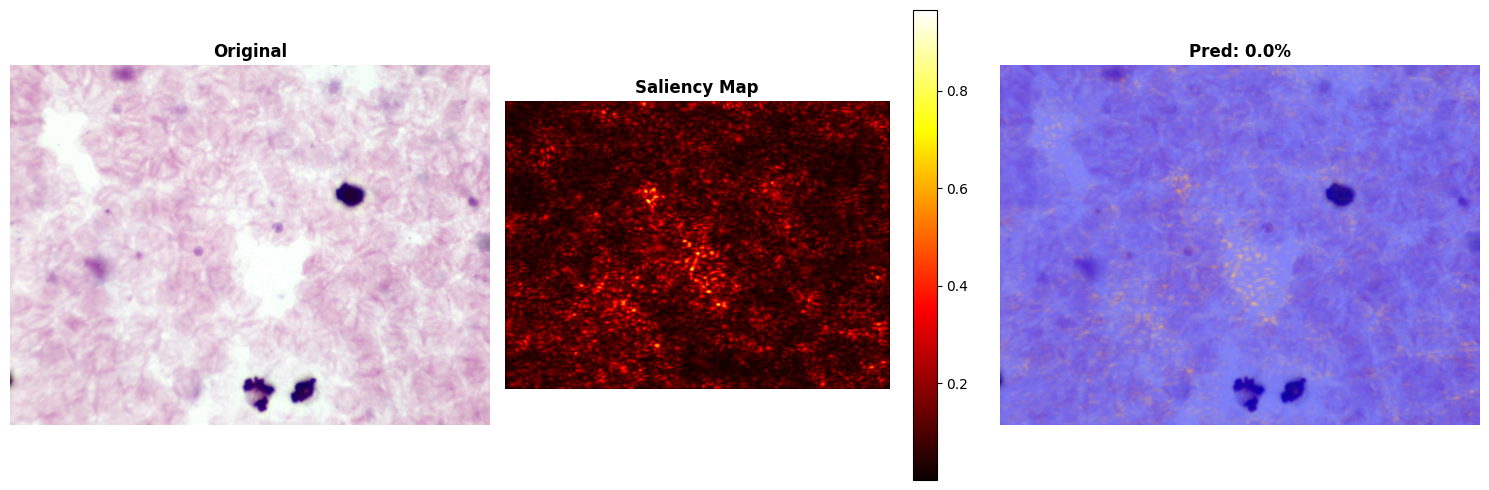

✓ Saved: saliency_analysis.png


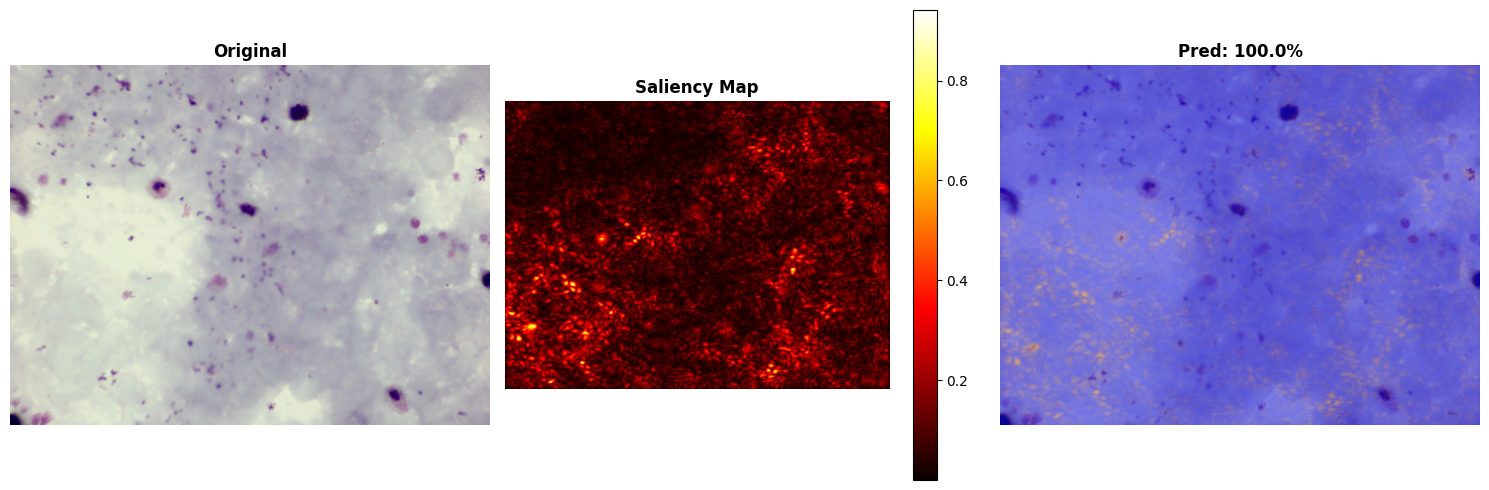

✓ Saved: saliency_analysis.png


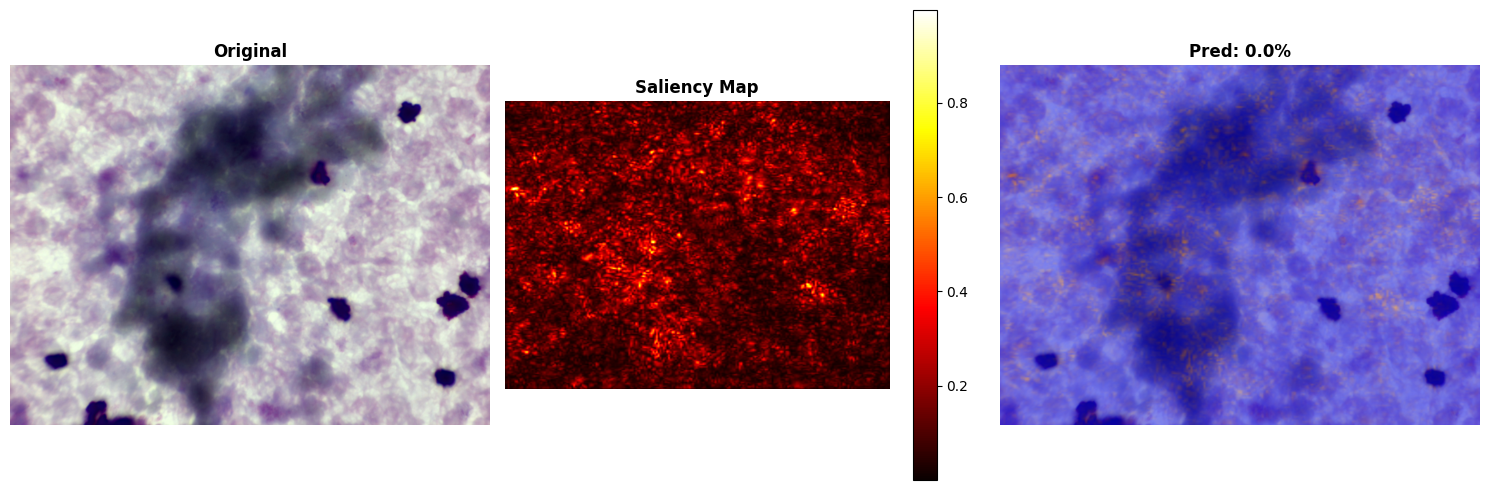

✓ Saved: saliency_analysis.png
✅ DONE!


In [23]:
print('Visualizing predictions...')
visualize_saliency(model, X_test[0])
visualize_saliency(model, X_test[1])
visualize_saliency(model, X_test[2])
print('✅ DONE!')


In [24]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model that outputs last conv layer and predictions
    grad_model = keras.models.Model(
        model.inputs, 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradient of predicted class w.r.t. last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Get gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Pool gradients across spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight feature maps by importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [25]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Apply jet colormap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Resize and overlay
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))


NameError: name 'Xtest' is not defined